# "Standing Ovation Model"
> "This is just a quick fun blog post about a model for standing ovations as proposed by Scott Page and John Miller - it provides a great introduction to agent based modelling for those unfamiliar.)"
- toc: true
- author: Lewis Cole (2020)
- branch: master
- badges: false
- comments: false
- categories: [Agent-Based-Model, Standing-Ovation]
- hide: false
- search_exclude: false
- image: https://github.com/lewiscoleblog/blog/raw/master/images/ovation/Funnel.jpg

## Standing Ovations - as a Phenomena
Although not particularly "exciting" for a subject to model, standing ovations have many interesting properties. A truly fantastic performance may elicit an instantaneous standing ovation whereby all audience members instinctively decide to stand. However this cannot be the only factor, we can observe in other performances a few hardcore fans may initially stand and then pass through the crowd as a "wave" through social pressure (or perhaps the inability to see the stage if others in front of you stand!) Eventually resulting in a standing ovation. At other times maybe only a handful of audience members stand, notice very few people around them are standing and then sheepishly sit down again. There is a clear temporal aspect to standing ovations but there is also some sense of criticality whereby a phase transition occurs. While understanding the mechanisms behind this for standing ovations may not have much "value" in of itself these principles turn up in many complex systems and so understanding here can be transferable to more "interesting" situations.

## Modelling Standard Ovations
We now move onto the question: how can we model standing ovations? We first consider the initial (instinctive) decision of standing or not following a performance. Clearly for a "perfect" performance (however that may be defined) everybody would show their appreciation and stand. However when the performance is not "perfect" why do some stand and some not? We could model each audience member as having some "error function" that clouds their judgement of the performance, so for (objectively) a good performance we could have that some percieve the performance as bad owing to their error function, and so they decide not to stand. We can express this mathematically: we denote the performance quality as $P$. Each individual has an error-rate $\epsilon$ - this defines a signal $S$ as:
$$ S = P + \epsilon $$
We can then state that an individual will stand for a signal that is in excess of their threshold $T$. We can take this threshold to be fixed for all individuals by adjusting their $\epsilon$ accordingly. 

But what does the error-rate represent? There are a number of interpretations. For example it could represent "stubborness", some may be difficult to impress. It could also represent differences in knowledge, somebody unfamiliar with jazz-club etiquette may stand/stay seated at the wrong times whereas somebody more seasoned will be more closely tied to the quality of the performance.

For arguments sake let's say that $P$ can vary from 0 to 1. The error rates are uniformly distributed. We can then code up this initial standing ovation model as below:

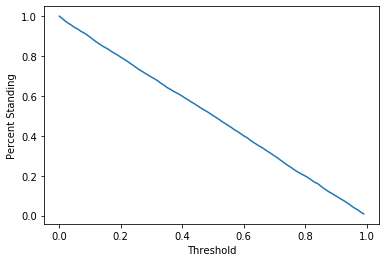

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set audience size
N = 50
M = 100

# Fix performance quality as 50%
P = 0.5

# Fix seed
np.random.seed(123)

# Fix all audience as seated (0) initially
audience = np.zeros((N, M))

# Set error functions for audience members
epsilon = np.random.random((N, M)) - 0.5

def initial_stand(error, p, t):
    signal = p + error
    out = signal > t
    return out * 1

# We set up an array to vary the threshold
T = np.arange(100) / 100
Pct = np.zeros(100)

# Loop over all thresholds and plot the percentage of audience standing
for i in range(100):
    Pct[i] = initial_stand(epsilon, P, T[i]).mean()

plt.plot(T, Pct)
plt.xlabel("Threshold")
plt.ylabel("Percent Standing")
plt.show()

As expected we get a straight line decreasing with threshold. From the discussion before we know that standing ovations are not entirely determined by the performance quality (and resulting threshold) behaviour. There is a social aspect to the phenomena. We now move onto looking at a temporal model. One way we could do this is that an individual takes a survey of all their neighbours and if enough of them are standing they also decide to stand (somewhat similar to the movement mechanism in a [Schelling Segregation Model](https://demonstrations.wolfram.com/SchellingsModelOfResidentialSegregation/)). However if you are sat in the audience it is unlikely you'll turn round to see what the people behind you are doing, you will only notice those in front of you. You may also notice those from many rows in front of you rather than just proximal neighbours. Page/Miller suggest a viewing "funnel" where each agent can see as:
![](https://github.com/lewiscoleblog/blog/raw/master/images/ovation/Funnel.jpg)

Where we can adjust the number of rows somebody can see as a paramter (with 3 presented here). We will make a small adjustment to this method; let's place more weight on the audience members closest to us. We will calculate the proportion standing in each row in or field of vision and take a weighted sum of these according to the square distance away (e.g. row 2 will be weighted 1/4 of row 1, row 3 will be 1/9 weighted and so on.) This should capture the behaviour that there is more social pressure from those around us, this might lead to a slow "wave" propagating through the audience as this pressure grows. For this model lets also assume that the lights are on in the theatre and we can see all rows up to the front in detail.

For this "funnel" we will ignore the proximal "next door" neighbours from this calculation. We will assume there is a different mechanism for these individuals, we will look at the proportion of neighbours standing (either 0, 0.5 or 1) and we will apply a "neighbour weight" which will weight between this score and the funnel score to give an overall social pressure score as:
$$ Social\_Pressure = (1 - neighbour\_weight) \times Funnel\_Pressure + neighbour\_weight \times Neighbour\_Pressure $$

We will use this mechanism of seperating out next door neighbours since if we go to a performance with others they will typically be sat next to us. Further one could argue that somebody is more likely to stand/sit based on their friend/partner's behaviour than those of a stranger. The neighbour weight parameter allows us to vary the relative importance.

Using the overall social pressure metric a sitting individual will stand if the social pressure exceeds a fixed threshold, similarly a standing individual will sit if the social pressure is smaller than one-less the fixed threshold. We are assuming that there is a symmetry invoked here which may not be the case. For example the "embarrassment" of standing while others are sitting might mean people are quicker to sit if they're in a small minority standing. However for a first quick and dirty implementation of a model the symmetry assumption will suffice (it will be easy enough to modify later should we desire).

We will also add 2 random components to this model: the first being a rate that if one is sitting down they stand up regardless of the information presented. The other being the reverse of this: a rate by which individuals sit down if they're standing. We will denote these rates as $\delta, \gamma$ respectively. This might allow for the possiblity of a "spontaneous ovation" occuring.

We now have one choice remaining before we can implement this model: how will the updates be made? There are 2 main classes of updates in an agent based model: asynchronous and synchronous. The former essentially means each agent updates "one by one", the order of upates can be random or by some defined order (in this example we could update those nearest the stage and iterate backwards for example). In a synchronous updating scheme all agents updated their state together once per time-step, of course by doing this one has to be careful in some situations (e.g. if there is an asset that can get depleted who gets to use it first?) but in this simple model there are no such concerns. For this model I think synchronous modelling is appropriate since I believe this is how ovations work in practice (e.g. we do not wait for "our turn" to make a decision), we could investigate how this affects the outcome later if we wish to. 

My implementation of this model can be seen below. We will look at how the proportion of audience members standing evolves over time (functions use njit decorator to simply improve run time - looping over the array multiple times in the funnel calculation is fairly slow in pure python):

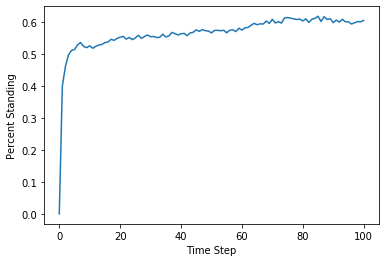

In [12]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

# Set audience size
N = 50
M = 100

# Fix performance quality as 50%
P = 0.5

# Fix Performance threshold
T = 0.6

# Fix seed
np.random.seed(123)

# Fix all audience as seated (0) initially
audience = np.zeros((N, M))

# Set error functions for audience members
epsilon = np.random.random((N, M)) - 0.5

# Fix number of timesteps
T_steps = 100
Pct_Hold = np.zeros(T_steps+1)

# Fix social pressure threshold
Pressure_T = 0.4

# Fix neighbour weight
N_weight = 0.5

# Fix probaility of spontaneous standing
delta = 0.1

# Fix probability of spontaneous sitting
gamma = 0.05

# Calculate initial reactions to performance
@njit
def initial_stand(error, p, t):
    signal = p + error
    out = signal > t
    return out * 1

# Function to calculate social pressure
@njit
def pressure(i, j, aud):
    rows = aud.shape[0]
    cols = aud.shape[1]
    pct_sum = 0
    norm = 0
    for x in range(i):
        active_row = i - x - 1
        left = max(j - (x+1), 0)
        right = min(j + (x+1), cols)
        pct_sum += aud[active_row, left:right+1].mean() / (x+1)**2
        norm += (x+1)**-2
    
    if norm == 0:
        res = 0
    else:
        res = pct_sum / norm
    
    return res

# Calculate pressure from (nextdoor) neighbours
@njit
def neighbour_pressure(i, j, aud):
    cols = aud.shape[1]
    count = 0
    left = 0
    right = 0
    if j != 0:
        left = aud[i, j-1]
        count += 1
    if j != cols -1:
        right = aud[i, j+1]
        count += 1
    return (left + right) / count
        
# Calculate overall pressure score
@njit
def pressure_score(i, j, aud, n_weight):
    return pressure(i, j, aud)*(1 - n_weight) + neighbour_pressure(i, j, aud)*n_weight

# Spontaneous sitting/standing function
@njit
def spontaneous(i, j, aud, dlt, gma):
    rnd = np.random.random()
    if aud[i,j] == 0 and rnd > (1-dlt):
        aud[i,j] = 1
    elif aud[i,j] == 1 and rnd > (1-gma):
        aud[i,j] = 0
    return aud

# Main Code Loop
audience = initial_stand(epsilon, P, T)
Pct_Hold[1] = audience.mean()

for x in range(2, T_steps+1):
    audience_old = audience.copy()
    for i in range(N):
        for j in range(M):
            up_score = pressure_score(i, j, audience_old, N_weight)
            down_score = pressure_score(i, j, 1 -audience_old, N_weight)
            if up_score > Pressure_T and audience_old[i,j] == 0:
                audience[i,j] = 1
            if down_score > Pressure_T and audience_old[i,j] == 1:
                audience[i,j] = 0
            spontaneous(i, j, audience, delta, gamma)
            Pct_Hold[x] = audience.mean()

plt.plot(Pct_Hold)
plt.xlabel("Time Step")
plt.ylabel("Percent Standing")
plt.show()

By selecting particular parameters we can see a few different behaviours in the model. These include an inital peak of enthusiasm that dies down, a gradual increase as the applause trickles from the front of the auditorium to the back and a rapturous applause leading to nearly all participants standing up very quickly. These are all behaviours that we do see in real life audiences. If we were particularly motivated we could look for real world phenomena in standing ovations and see if these rules are able to replicate them.

## Potential Improvements
With agent based models there are always "extra" things that could be added/modified. A few select suggestions include:
* Revisit the "funnel" mechanism and compare various schemes
* What happens if there are various levels/balconies or perhaps aisles between seats?
* What happens with "stooges"? That is if we add agents who always applaud regardless, what is the minimum number required to guarantee a standing ovation? Where are they best placed (perhaps taking into account ticket cost - 10 in the middle compared to 2 at the front), etc.
* We could code in "partners" or "groups" more precisely to investigate the impact that has
* How does changing to asynchronous updating change the behaviour?
* What if every so often an agent "turns round" to view the seats behind them?
* and so on

## Conclusion
We have seen how we can code up a basic agent based model for standing ovations. While the subject itself isn't particularly "useful" in of itself the principles are common to many other systems. We have also seen some of the considerations that go into an agent based model.

As a final remark it is worth noting that this is not how you would produce an agent based model in practice. Typically you would start with a simple model and add features gradually and test the impact, I did not want to write a series of long posts on this model so I "skipped to the end" coding in what I thought some pertinent features could be all at once (although I did not spend long thinking about them!)

## References
The original paper on standing ovation models presented by Scott Page and John Miller ([can be seen here!](https://www2.econ.iastate.edu/tesfatsi/StandingOvation.MillerPage.pdf) for those wanting to read more about their version of the model.